In [1]:
import numpy as np
import json 
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import DBSCAN

# Get digital ink for firestore db

In [2]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import glob

json_file = glob.glob("*.json")[0]

cred = credentials.Certificate(json_file)
firebase_admin.initialize_app(cred, {
    'projectId': 'digital-pen-746a6',
})

db = firestore.client()
doc_id = "THJc0rm2wzZaiNwFhcTa"
doc_ref = db.collection("ink").document(doc_id)

doc = doc_ref.get()

filename = "../data/uploaded_ink/" + doc_id + ".json"

if doc.exists:
    ink = doc.to_dict()
    with open(filename, 'w') as fp:
        json.dump(ink, fp)
else:
    print(u'No such document!')

# Format user uploaded digital ink 


In [3]:
with open("../data/uploaded_ink/THJc0rm2wzZaiNwFhcTa.json") as f:
    ink = json.load(f)

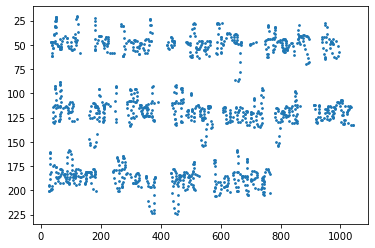

In [4]:
plt.scatter(ink["x"], ink["y"], s = 3)
plt.gca().invert_yaxis()
plt.show()

## Segment ink into individual lines

In [5]:
X = np.swapaxes(np.array([ink["x"], ink["y"], ink["t"]]), 0 , 1)

scaler = StandardScaler().fit(X)

X_norm = normalize(X, axis=0)
X_scaled = scaler.transform(X)

In [6]:
clustering = DBSCAN(eps=0.3, min_samples=5).fit(X_scaled)
labels = clustering.labels_

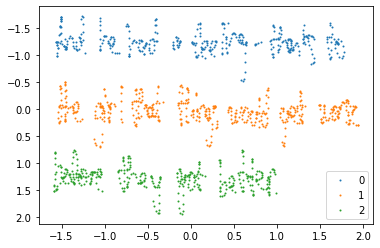

In [16]:
u_labels = np.unique(clustering.labels_)

for i in u_labels:
    plt.scatter(X_scaled[labels == i , 0] , X_scaled[labels == i , 1] , label = i, s = 1)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [8]:
textLines = []

for label in u_labels:
    textLine = {} 
    textLine["x"] = np.array(np.array(ink["x"])[labels == label])
    textLine["y"] = np.array(np.array(ink["y"])[labels == label])
    textLine["t"] = np.array(np.array(ink["t"])[labels == label])
    textLine["p"] = np.array(np.array(ink["p"])[labels == label])

    textLines.append(textLine)

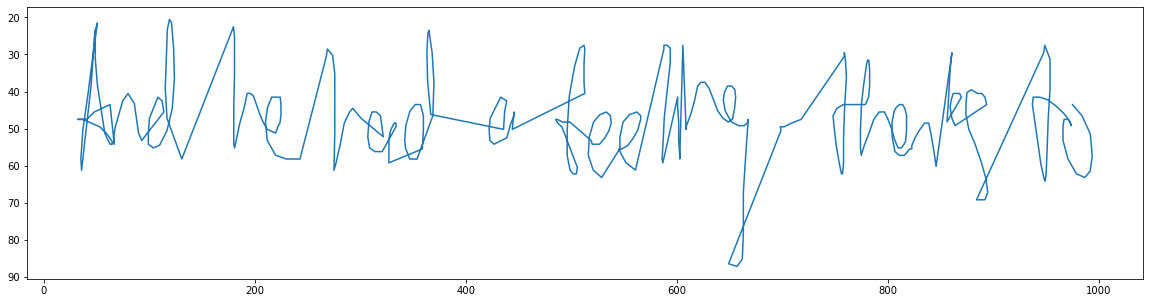

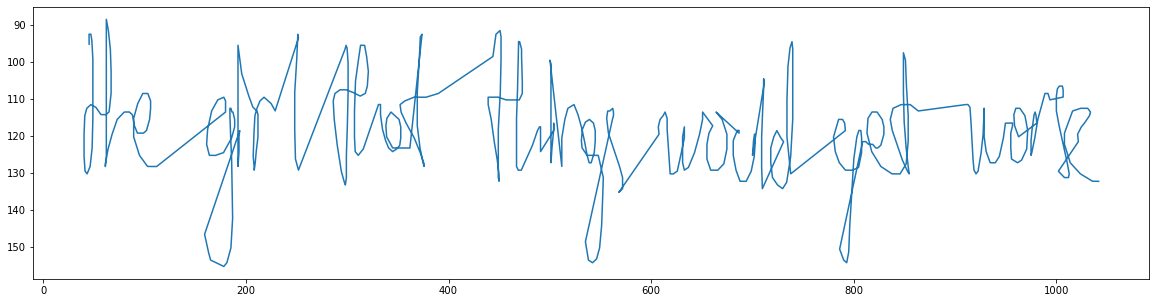

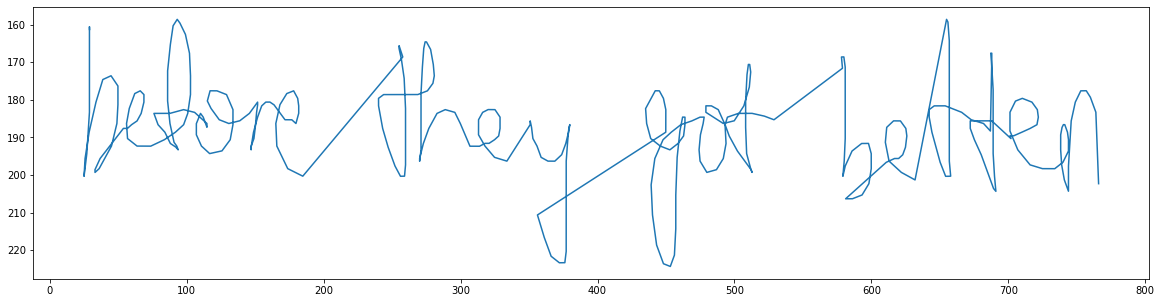

In [9]:
for textLine in textLines:
    plt.figure(figsize=(20,5))
    plt.plot(textLine["x"], textLine["y"])
    plt.gca().invert_yaxis()
    plt.show()

## Create evenly space time series for each line of text

In [10]:
textLines_filled = []

for textLine in textLines:
    x = textLine["x"]
    y = textLine["y"]
    t = textLine["t"]
    p = textLine["p"]
    
    print("Old x:", x[0])

    start_t = t[0]
    end_t = t[len(t) - 1]

    t_filled = np.arange(start_t, end_t, 13)
    x_filled = np.interp(t_filled, t, x)
    y_filled = np.interp(t_filled, t, y)
    p_filled = np.interp(t_filled, t, p)
    
    print("New x:", x_filled[0])

    textLine_filled = {} 
    textLine_filled["x"] = x_filled
    textLine_filled["y"] = y_filled
    textLine_filled["t"] = t_filled
    textLine_filled["p"] = p_filled

    textLines_filled.append(textLine_filled)

Old x: 49.0
New x: 49.0
Old x: 45.159160935847694
New x: 45.159160935847694
Old x: 29.159113554945296
New x: 29.159113554945296


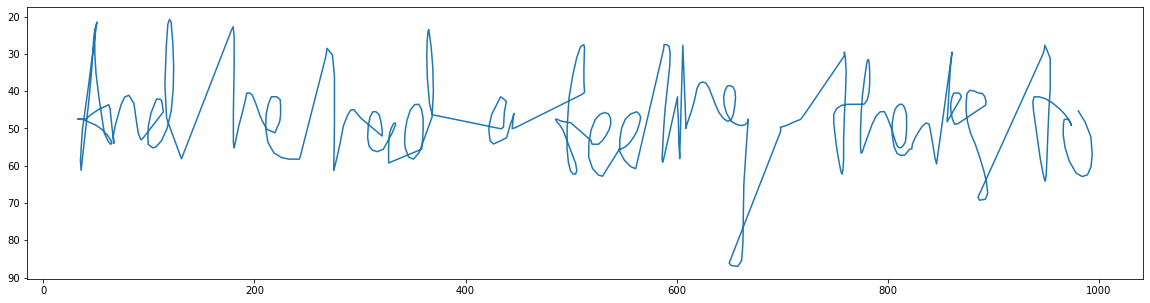

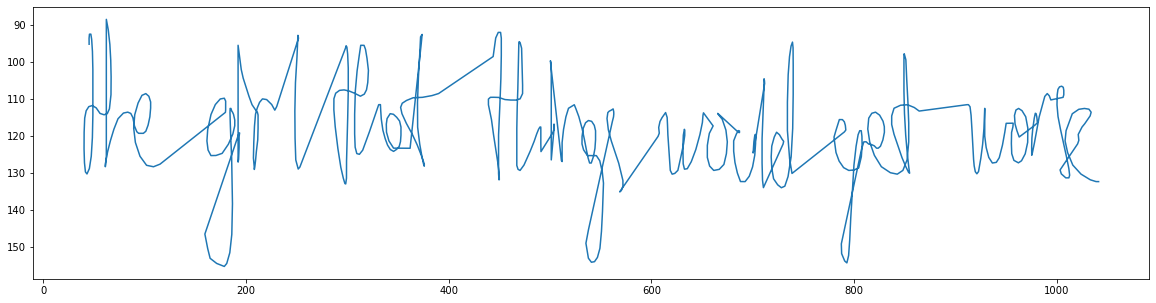

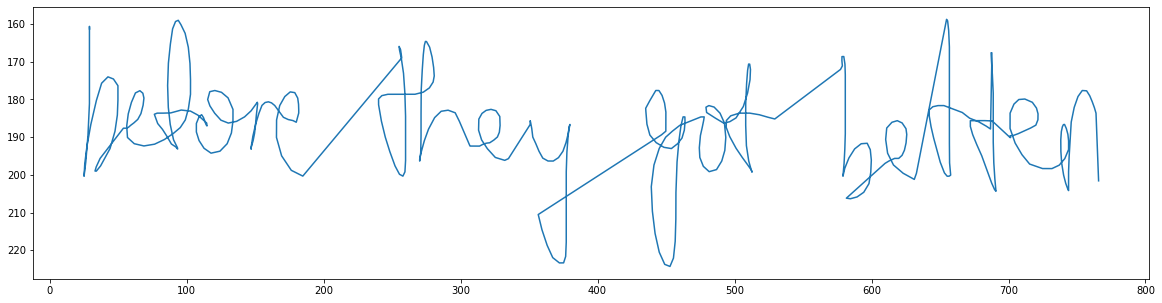

In [11]:
for textLine in textLines_filled:
    x_filled = textLine["x"]
    y_filled = textLine["y"]

    plt.figure(figsize=(20,5))
    plt.plot(x_filled, y_filled)
    plt.gca().invert_yaxis()
    plt.show()

## Splice text lines together into a single line 

In [14]:
merged_textLine = {}
merged_textLine["x"] = textLines_filled[0]["x"]
merged_textLine["y"] = textLines_filled[0]["y"]
merged_textLine["t"] = textLines_filled[0]["t"]
merged_textLine["p"] = textLines_filled[0]["p"]

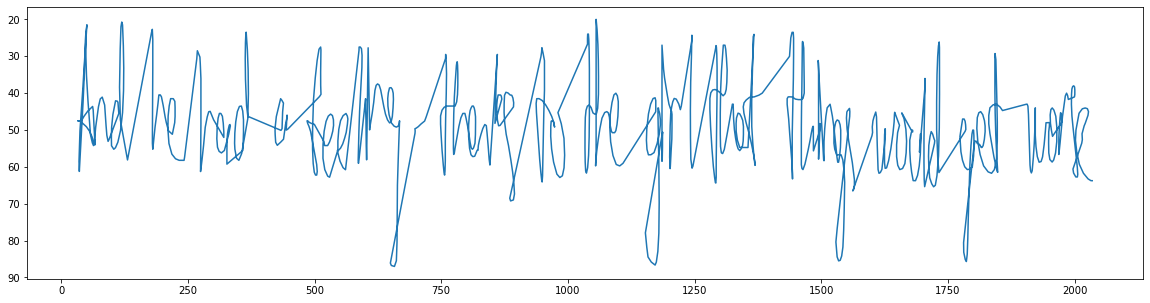

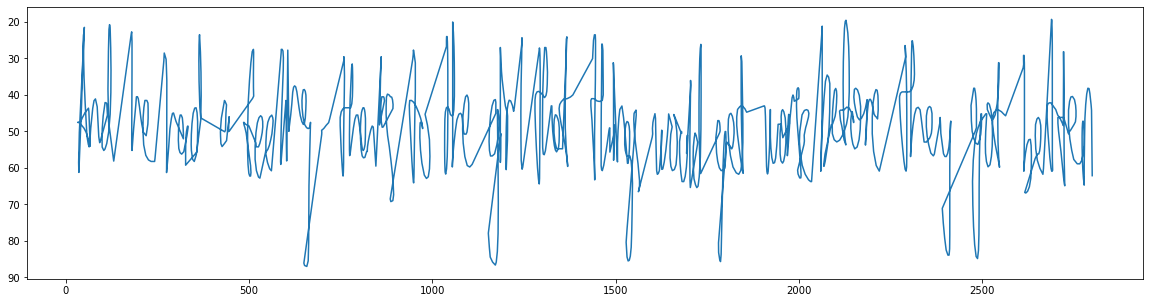

In [15]:
# Determine the y-mean and x-last of the first line 
x_right_last = np.max(textLines_filled[0]["x"])
y_mean_1 = np.mean(textLines_filled[0]["y"])

# For each line after the first 
for i in range(1, len(textLines_filled)):
    textLine = textLines_filled[i]

    # Get the x-start and y_mean of the new line 
    # x_left_curr = np.max(textLine["x"])
    y_mean_curr = np.mean(textLine["y"])
    
    # Add x_right_last to all x values of the next line
    x = textLine["x"]

    x_new = x + x_right_last
    
    x_right_last = np.max(x_new)
    
    # Minus the difference of means to y values 
    y = textLine["y"]
    y_new = y + y_mean_1 - y_mean_curr
    
    merged_textLine["x"] = np.append(merged_textLine["x"], x_new)
    merged_textLine["y"] = np.append(merged_textLine["y"], y_new)
    merged_textLine["t"] = np.append(merged_textLine["t"], textLine["t"])
    merged_textLine["p"] = np.append(merged_textLine["p"], textLine["p"])
    
    plt.figure(figsize=(20,5))
    plt.plot(merged_textLine["x"], merged_textLine["y"])
    plt.gca().invert_yaxis()
    plt.show()